# Lesson 3: Practical Deep Learning for Coders - Neural net foundations

This notebook presents my personal notes and work coming from my experience with the 3rd lesson of the course "Practical Deep Learning" by Jeremy Howard ([here](https://www.youtube.com/watch?v=hBBOjCiFcuo&t=4s) for the video on YT) and the related fastbook, the Jupyter-Book from fast.ai. The lecture is based on the chapter 4  of the book.

The lesson explains what was going on in previous lectures. It discusses what a learner is and what training it means.

Lesson structure:
- What have we done so far? 
- How does a neural net really work?
- How a neural network approximates any given function?
- Build a regression model in spreadsheet;
- Matrix multiplication makes training faster;
- Homework

In [ ]:
# Install the required packages
! pip install -r requirements.txt

## What have we done so far?

Let's laod our trained learner and look at its structure

In [2]:
# load model from previous lesson
from fastai.vision.all import load_learner
# We may have some problem in Linux/Windows porting, check this https://forums.fast.ai/t/cannot-instantiate-windowspath-when-loading-learner/86564
learn = load_learner('../02_deployment/minima/model.pkl')
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Our model is a deep one; it contains multiple layers, and many of these layers consist of sublayers. What is all this stuff?

In [3]:
l = learn.model.get_submodule('0.0')
list(l.parameters())

[Parameter containing:
 tensor([[[[-1.0431e-02, -6.1526e-03, -1.8345e-03,  ...,  5.6587e-02,
             1.7056e-02, -1.2723e-02],
           [ 1.1068e-02,  9.5084e-03, -1.0995e-01,  ..., -2.7126e-01,
            -1.2910e-01,  3.7210e-03],
           [-6.9631e-03,  5.9062e-02,  2.9545e-01,  ...,  5.1969e-01,
             2.5630e-01,  6.3555e-02],
           ...,
           [-2.7557e-02,  1.6013e-02,  7.2557e-02,  ..., -3.3288e-01,
            -4.2060e-01, -2.5784e-01],
           [ 3.0589e-02,  4.0925e-02,  6.2809e-02,  ...,  4.1380e-01,
             3.9356e-01,  1.6603e-01],
           [-1.3763e-02, -3.7108e-03, -2.4123e-02,  ..., -1.5073e-01,
            -8.2258e-02, -5.8058e-03]],
 
          [[-1.1406e-02, -2.6633e-02, -3.4668e-02,  ...,  3.2483e-02,
             6.2552e-04, -2.5773e-02],
           [ 4.5672e-02,  3.3583e-02, -1.0455e-01,  ..., -3.1256e-01,
            -1.6054e-01, -1.3168e-03],
           [-8.5566e-04,  9.8395e-02,  4.0207e-01,  ...,  7.0785e-01,
             3.6

Each layer in our network has a lot of paramenters. Our model consists in a incredible number of parameters, but how they are use by our model?

## How does a neural net really work?

Okay, let's delve deeper into the subject! This section is based on the notebook [How does a NN really work?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work) by Jeremy.


A neural network (NN) is essentially a mathematical function attempting to estimate a non-linear function. Imagine having a mathematical function that we are interested in estimating, for example, to predict how a time series evolves. In most situations, we only have a limited amount of available data. Let's explain this practically!


Let's create a function and try to estimate it!

In [4]:
from ipywidgets import interact
from fastai.basics import plt, torch

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

### Define a quadratic function

Herein, we define a quadratic function, setting-up its parameters. We can plot is just using the utility function provided above.

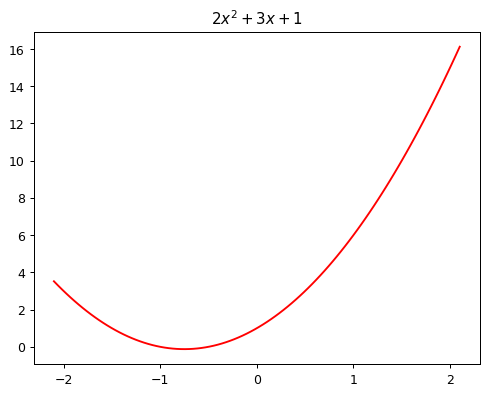

In [6]:
def f(x): return 2*x**2 + 3*x + 1
plot_function(f, "$2x^2 + 3x + 1$")

Let's define a utility function that calculates the value of a point on any quadratic function

In [7]:
def quad(a, b, c, x): return a*x**2 + b*x + c

If we fix some particular values of `a`, `b`, and `c`, then we'll have made a quadratic. To fix values passed to a function in python, we use the  `partial` function, like so:

In [10]:
from fastai.basics import partial
def mk_quad(a,b,c): return partial(quad, a,b,c)

Ok, we have created a function that, given its parameter, return a quadratic function as a python function!

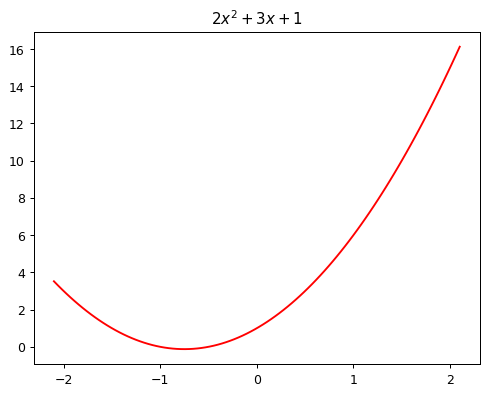

In [11]:
f2 = mk_quad(2,3,1)
plot_function(f2, "$2x^2 + 3x + 1$")

Now, for our example, let's suppose we have data sampled from this function. In real-world data, we have noise (i.e., random values affecting our observations). Hence, let's generate some synthetic data.

### Sample synthetic data

In [12]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

Let's use the now to create our noisy measurements based on the quadratic above:

In [14]:
from fastai.basics import np
np.random.seed(42)
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

In [15]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[ 5.4220],
         [ 1.6551],
         [ 1.4720],
         [-1.3510],
         [-0.6161]], dtype=torch.float64))

We're not going to learn much about our data by just looking at the raw numbers, so let's draw a picture:

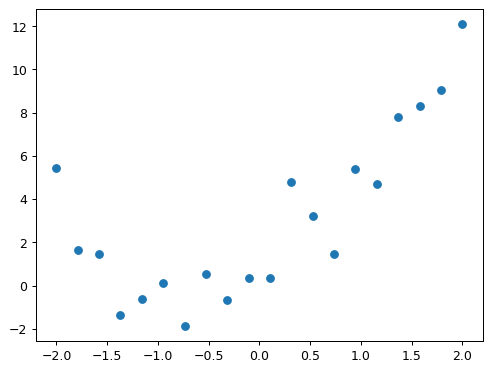

In [16]:
plt.scatter(x,y);

### Estimate the function manually!

A neural network aims to estimate the original function. In this example, we know that our function is quadratic, and we are interested in estimating its parameters.
How do we find values of `a`, `b`, and `c` which fit this data? One approach is to try a few values and see what fits. Here's a function which overlays a quadratic on top of our data, along with some sliders to change `a`, `b`, and `c`, and see how it looks:

In [17]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

Try moving slider `a` a bit to the left. Does that look better or worse? How about if you move it a bit to the right? Find out which direction seems to improve the fit of the quadratic to the data, and move the slider a bit in that direction. Next, do the same for slider `b`: first figure out which direction improves the fit, then move it a bit in that direction. Then do the same for `c`.

OK, now go back to slider `a` and repeat the process. Do it again for `b` and `c` as well.


Did you notice that by going back and doing the sliders a second time that you were able to improve things a bit further? That's an important insight -- it's only after changing `b` and `c`, for instance, that you realise that `a` actually needs some adjustment based on those new values.

### Add a Loss function!

One thing that's making this tricky is that we don't really have a great sense of whether our fit is really better or worse. It would be easier if we had a numeric measure of that. On easy metric we could use is **mean absolute error**, which is the distance from each data point to the curve:

In [18]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

We'll update our interactive function to print this at the top for us.

Use this to repeat the approach we took before to try to find the best fit, but this time just use the value of the metric to decide which direction to move each slider, and how far to move it.

This time around, try doing it in the opposite order: `c`, then `b`, then `a`.

You'll probably find that you have to go through the set of sliders a couple of times to get the best fit.

In [19]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

### Automating gradient descent

In a modern neural network we'll often have tens of millions of parameters to fit, or more, and thousands or millions of data points to fit them to. We're not going to be able to do that by moving sliders around! We'll need to automate this process.

Thankfully, that turns out to be pretty straightforward. We can usderivativesus to figure out, for each parameter, whether we should increase or decrease i Indeed, derivatives measure the rate of change of a function. Actually, we don't even need to calculate them ourselves, because the computer (i.e. pytorch) will do it for us!

The basic idea is this: if we know the gradient of our `mae()` function with respect to our parameters, `a`, `b`, and `c`, then that means we know how adjusting (for instance) a will change the value of `mae()`. If, say, a has a **negative gradient**, then we know that increasing a will decrease `mae()`. Then we know that's what we need to do, since we trying to make `mae()` as low as possible.

So, we find the gradient of `mae()` for each of our parameters, and then adjust our parameters a bit in the **opposite direction to the sign of the gradient**.

To do this, first we need a function that takes all the parameters `a`, `b`, and `c` as a single vector input, and returns the value `mae()` based on those parameters:

In [20]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

Let's try it:

In [21]:
quad_mae([1.1, 1.1, 1.1])

tensor(1.8561, dtype=torch.float64)

Yup, that's the same as the starting  `mae()` we had in our plot before.

We're first going to do exactly the same thing as we did manually -- pick some arbritrary starting point for our parameters. We'll put them all into a single tensor:

In [22]:
abc = torch.tensor([1.1,1.1,1.1])

To tell PyTorch that we want it to calculate gradients for these parameters, we need to call `requires_grad_()`:

In [23]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

We can now calculate `mae()`. Generally, when doing gradient descent, the thing we're trying to minimise is called the **loss**:

In [24]:
loss = quad_mae(abc)
loss

tensor(1.8561, dtype=torch.float64, grad_fn=<MeanBackward0>)

To get PyTorch to now calculate the gradients, we need to call `backward()`

In [25]:
loss.backward()

The gradients will be stored for us in an attribute called `grad`:

In [26]:
abc.grad

tensor([-0.3446, -0.7684,  0.1000])

According to these gradients, all our parameters are a little low. So let's increase them a bit. If we subtract the gradient, multiplied by a small number, that should improve them a bit:

In [27]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)
    
print(f'loss={loss:.2f}')

loss=1.85


Yes, our loss has gone down!

The "small number" we multiply is called th**e learning ra**te, and is the most important **hyper-parameter** to set when training a neural network.

BTW, you'll see we had to wrap our calculation of the new parameters in with `torch.no_grad()`. That disables the calculation of gradients for any operations inside that context manager. We have to do that, because `abc -= abc.grad*0.01` isn't actually part of our quadratic model, so we don't want derivitives to include that calculation.

We can use a loop to do a few more iterations of this:

In [28]:
for i in range(20):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=1.85
step=1; loss=1.83
step=2; loss=1.81
step=3; loss=1.78
step=4; loss=1.75
step=5; loss=1.71
step=6; loss=1.65
step=7; loss=1.60
step=8; loss=1.53
step=9; loss=1.46
step=10; loss=1.38
step=11; loss=1.31
step=12; loss=1.24
step=13; loss=1.17
step=14; loss=1.12
step=15; loss=1.07
step=16; loss=1.05
step=17; loss=1.04
step=18; loss=1.07
step=19; loss=1.10


As you can see, our loss keeps going down!

If you keep running this loop for long enough however, you'll see that the loss eventually starts increasing for a while. That's because once the parameters get close to the correct answer, our parameter updates will jump right over the correct answer! To avoid this, we need to decrease our learning rate as we train. This is done using a learning rate schedule, and can be automated in most deep learning frameworks, such as fastai and PyTorch.

## How a neural network approximates any given function?

But neural nets are much more convenient and powerful than this example showed, because we can learn much more than just a quadratic with them. How does that work?

The trick is that a neural network is a very expressive function. In fact -- it's infinitely expressive (look at [here](https://en.wikipedia.org/wiki/Universal_approximation_theorem)). A neural network can approximate any computable function, given enough parameters. A "computable function" can cover just about anything you can imagine: understand and translate human speech; paint a picture; diagnose a disease from medical imaging; write an essay; etc...

The way a neural network approximates a function actually turns out to be very simple. The key trick is to combine two extremely basic steps:

- Matrix multiplication, which is just multiplying things together and then adding them up;
- The function `max(x,0)`, which simply replaces all negative numbers with zero.


In PyTorch, the function `max(x,0)` is written as `np.clip(x,0)`. The combination of a linear function and this `max()` is called a **rectified linear function**, and it can be implemented like this:

In [29]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

Here's what it looks like:

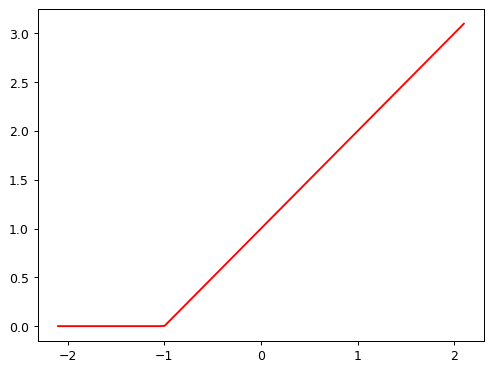

In [30]:
plot_function(partial(rectified_linear, 1,1))

BTW, instead of `torch.clip(y, 0.)`, we can instead use `F.relu(x)`, which does exactly the same thing. In PyTorch, F refers to the `torch.nn.functional` module.

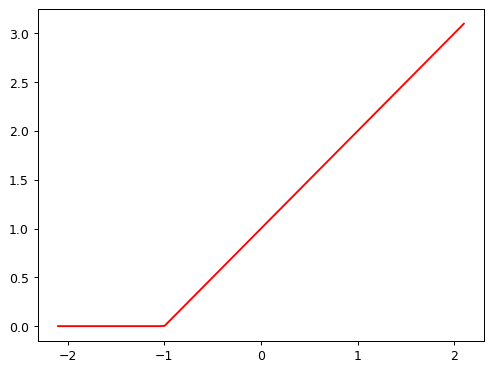

In [31]:
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

To understand how this function works, try using this interactive version to play around with the parameters `m` and `b`:

In [32]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

As you see, `m` changes the slope, and `b` changes where the "hook" appears. This function doesn't do much on its own, but look what happens when we add two of them together:

In [33]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

If you play around with that for a while, you notice something quite profound: with enough of these rectified linear functions added together, you could approximate any function with a single input, to whatever accuracy you like! Any time the function doesn't quite match, you can just add a few more additions to the mix to make it a bit closer. As an experiment, perhaps you'd like to try creating your own `plot_triple_relu` interactive function, and maybe even include the scatter plot of our data from before, to see how close you can get?

This exact same approach can be expanded to functions of 2, 3, or more parameters.

In [35]:
def triple_relu(m1,b1,m2,b2,m3,b3,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x) + rectified_linear(m3,b3,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5, m3=1.5, b3=1.5)
def plot_triple_relu(m1, b1, m2, b2, m3, b3):
    plot_function(partial(triple_relu, m1,b1,m2,b2,m3, b3), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

## How to recognise an owl
OK great, we've created a nifty little example showing that we can drawing squiggly lines that go through some points. So what?

We have just derived deep-learning! everything from now, are tricks to make it faster and make it need less data. This is it!


Well... the truth is that actually drawing squiggly lines (or planes, or high-dimensional hyperplanes...) through some points is literally all that deep learning does! If your data points are, say, the RGB values of pixels in photos of owls, then you can create an owl-recogniser model by following the exact steps above.

This may, at first, sound about as useful as the classic "how to draw an owl" guide:

![owl](images/howtodrawanowl.png)


People often ask "OK, but how do neural nets actually work". But at a foundational level, there is no "step 2". We're done -- the above steps will, given enough time and enough data, create (for example) an owl recogniser, if you feed in enough owls (and non-owls).

The devil, is in the "given enough time and enough data" part of the above sentence. There's a lot of tweaks we can make to reduce both of these things. For instance, instead of running our calculations on a normal CPU, as we've done above, we could do thousands of them simultaneously by taking advantage of a GPU. We could greatly reduce the amount of computation and data needed by using a convolution instead of a matrix multiplication, which basically means skipping over a bunch of the multiplications and additions for bits that you'd guess won't be important. We could make things much faster if, instead of starting with random parameters, we start with parameters of someone else's model that does something similar to what we want (this is called transfer learning).


When you have ReLUs getting added together and gradient descent optimize parameters, and samples of input and output you want, the computer will draw the owl!
Keep calm and remind youself that deep-learning is ReLUs + gradient-descent!

## Build a regression model in spreadsheet





at a start of a project, jeremy would use res-net18 and try cleaning, augmentation, external data and so on as mush fast as possible. training better architecture is the last thing you can do

Start training model on day one!

Learning rate, hyper-parameter! How to pick? it could considerly impact the performance, fine_tuning set reseanable lr for us, but may we can change it to match for our problem!

matrix multiplication
http://matrixmultiplication.xyz/
GPUs are good in matrix multiplications thanks to tensor-core

In [ ]:
# titanic competition.... excel... select just people with not nan.. categorical encoding
# starting from random numbers..
# normalization
# for distribution like money, log non-linearity

In [ ]:
# Getting started with NLP for absolute beginners (notebook)